In [1]:
import torch
import torch.optim as optim
import torch.nn as nn

from models import models
from utils import utils

In [2]:
# Create the Generator and Discriminator and print their architectue
output_space_dim = 2
latent_space_dim = 5
discriminator = models.Discriminator(output_space_dim)
generator = models.Generator(latent_space_dim, output_space_dim)
print(discriminator)
print(generator)

Discriminator(
  (linear_leakyrelu_stack): Sequential(
    (0): Linear(in_features=2, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=25, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Generator(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=15, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=15, out_features=2, bias=True)
  )
)


In [3]:
# Define the function we are trying to embed
def f(x):
    return x**3

In [4]:
# Train the GAN 
func = f
discriminator.train()
generator.train()
batch_size = 8

gen_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()), lr=0.0003)
dis_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()), lr=0.003)
criterion = nn.BCELoss()

for i in range(20001):
    # Train the discriminator first
    X_generated, y_generated = utils.run_generator(generator, batch_size)
    X_real, y_real = utils.generate_ground_truth(func, batch_size)
    dis_loss = criterion(discriminator(X_generated), y_generated) + criterion(discriminator(X_real), y_real)
    
    # Backprop and update the discriminator
    dis_optimizer.zero_grad()
    dis_loss.backward()
    dis_optimizer.step()
    
    # Time to train the Generator
    X_generated, y_generated = utils.run_generator(generator, batch_size)
    gen_loss = criterion(discriminator(X_generated), torch.ones_like(y_generated)) # Note the flipped target values
    
    # Backprop and update the generator
    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()
    
    # Print losses every few iterations
    if i % 2000 == 0:
        print("epoch: {} discriminator loss: {} generator loss: {}".format(i, dis_loss.item(), gen_loss.item()))
#     del X_generated, gen_loss
    

epoch: 0 discriminator loss: 1.489464521408081 generator loss: 0.6111365556716919
epoch: 2000 discriminator loss: 1.3948113918304443 generator loss: 0.7131575345993042
epoch: 4000 discriminator loss: 1.380855917930603 generator loss: 0.7080903053283691
epoch: 6000 discriminator loss: 1.3795185089111328 generator loss: 0.6776439547538757
epoch: 8000 discriminator loss: 1.3296706676483154 generator loss: 0.726732611656189
epoch: 10000 discriminator loss: 1.4316630363464355 generator loss: 0.6775069236755371
epoch: 12000 discriminator loss: 1.360097885131836 generator loss: 0.7192155718803406
epoch: 14000 discriminator loss: 1.3699898719787598 generator loss: 0.6922861337661743
epoch: 16000 discriminator loss: 1.3480926752090454 generator loss: 0.700426459312439
epoch: 18000 discriminator loss: 1.3960089683532715 generator loss: 0.7000359296798706
epoch: 20000 discriminator loss: 1.4268560409545898 generator loss: 0.7315393686294556


In [5]:
# Generate some data after training
func = f
generator.eval()
data, labels = utils.run_generator(generator, 75)
data = data.detach().numpy()
data_gt, labels = utils.generate_ground_truth(func, 50)
# print(data)

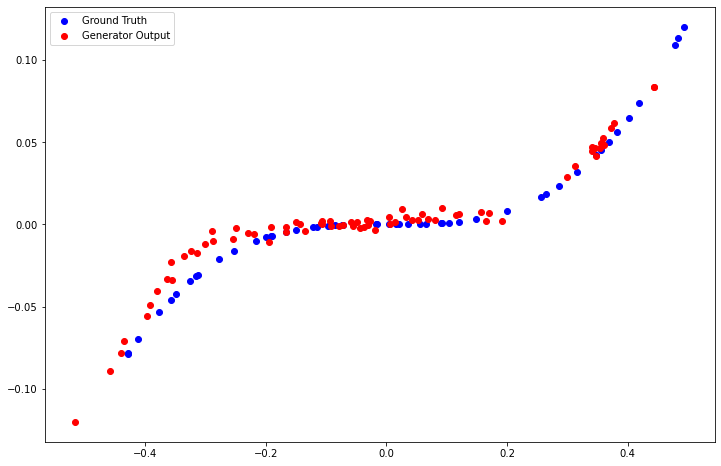

In [6]:
# Plot result agains the function we were trying to learn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(data_gt[:, 0], data_gt[:, 1], color='blue', label='Ground Truth')
plt.scatter(data[:, 0], data[:, 1], color='red', label='Generator Output')
plt.legend()